# LTSM

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_percentage_error

2024-11-03 17:13:35.039369: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data = pd.read_pickle('../data/data.pkl') 

In [3]:
# List of features
features = ['price', 'wind_offshore', 'wind_onshore', 'solar', 'total_load']


In [4]:
data = data[features]

## Train-test split

In [5]:
# 1. Train-Test Split (keeping all hourly data points in the last 7 days of each month for testing)
def train_test_split(data):
    test_indices = data.index.to_series().groupby([data.index.year, data.index.month]).apply(lambda x: x[-24*7:])
    test_data = data.loc[test_indices]
    train_data = data.drop(test_indices)
    return train_data, test_data

train_data, test_data = train_test_split(data)

In [6]:
print(len(train_data), len(test_data))

13487 4033


## Sequences

In [101]:
# 2. Create Sequences for LSTM Model
def create_sequences(data, seq_length=24, target_column='price'):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i+seq_length].values)  # Include all features in X
        y.append(data[target_column].iloc[i+seq_length])  # Target is still the original 'price'
    return np.array(X), np.array(y)

In [8]:
# Set sequence length (e.g., 24 for daily patterns)
seq_length = 24
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

## LSTM

In [9]:
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, activation='relu', input_shape=input_shape),
        Dropout(0.2),  # Dropout to prevent overfitting
        Dense(1)  # Output layer with a single neuron for regression
    ])
    model.compile(optimizer='adam', loss='mae')
    return model

# Determine the input shape for the model (seq_length, number of features)
input_shape = (X_train.shape[1], X_train.shape[2])

In [10]:
# Initialize and train the model
lstm_model = create_lstm_model(input_shape)
lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)


Epoch 1/10


/Users/libin/anaconda3/envs/th/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


379/379 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 11137.3809 - val_loss: 795.7797
Epoch 2/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 685.9171 - val_loss: 95.4514
Epoch 3/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 121.1853 - val_loss: 91.7113
Epoch 4/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 106.5393 - val_loss: 98.7952
Epoch 5/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 104.1153 - val_loss: 94.2701
Epoch 6/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 105.2096 - val_loss: 88.4329
Epoch 7/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 102.6403 - val_loss: 88.9629
Epoch 8/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 104.0592 - val_loss: 83.5639
Epoch 9/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 102.6855 - val_loss: 98.6811
Epoch 10/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 107.1393 - val_loss: 89.8470


In [11]:
# 4. Evaluate the Model
# Define sMAPE function for evaluation
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Make predictions and calculate sMAPE
lstm_preds = lstm_model.predict(X_test)
lstm_smape = smape(y_test, lstm_preds)
print(f"LSTM sMAPE: {lstm_smape:.2f}")

126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
LSTM sMAPE: 51.04


In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Calculate MAE
mae = mean_absolute_error(y_test, lstm_preds)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, lstm_preds))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Mean Absolute Error (MAE): 109.49
Root Mean Squared Error (RMSE): 152.03


## Improved

In [13]:
data_im = data.copy()

In [14]:
# Extract datetime-based features
data_im['DayOfWeek'] = data.index.dayofweek              # Day of the week (0=Monday, 6=Sunday)
data_im['WeekOfYear'] = data.index.isocalendar().week    # ISO week number of the year
data_im['Day'] = data.index.day                          # Day of the month
data_im['Month'] = data.index.month                      # Month of the year
data_im['Year'] = data.index.year                        # Year
data_im['PeriodOfDay'] = data.index.hour                 # Hour of the day (0-23)

In [15]:
data_im.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17520 entries, 2022-01-01 01:00:00 to 2024-01-01 00:00:00
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          17520 non-null  float64
 1   wind_offshore  17520 non-null  int64  
 2   wind_onshore   17520 non-null  int64  
 3   solar          17520 non-null  int64  
 4   total_load     17520 non-null  int64  
 5   DayOfWeek      17520 non-null  int32  
 6   WeekOfYear     17520 non-null  UInt32 
 7   Day            17520 non-null  int32  
 8   Month          17520 non-null  int32  
 9   Year           17520 non-null  int32  
 10  PeriodOfDay    17520 non-null  int32  
dtypes: UInt32(1), float64(1), int32(5), int64(4)
memory usage: 1.7 MB


In [81]:
features = ['price', 'wind_offshore', 'wind_onshore', 'solar', 'total_load', 
            'DayOfWeek', 'WeekOfYear', 'Day', 'Month', 'Year', 'PeriodOfDay']
# features = ['price',
            # 'DayOfWeek', 'WeekOfYear', 'Day', 'Month', 'Year', 'PeriodOfDay']

In [82]:
data_im = data_im[features]

In [83]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data_im), columns=data_im.columns, index=data_im.index)

In [84]:
train_data, test_data = train_test_split(data_scaled)

In [85]:
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

In [86]:
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, activation='relu', input_shape=input_shape),
        Dropout(0.2),  # Regularization to prevent overfitting
        Dense(1)  # Output layer for regression
    ])
    model.compile(optimizer='adam', loss='mae')
    return model

# Set input shape for the LSTM
input_shape = (X_train.shape[1], X_train.shape[2])

In [87]:
# Initialize and train the model
lstm_model = create_lstm_model(input_shape)
lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)


Epoch 1/10


/Users/libin/anaconda3/envs/th/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


379/379 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1111 - val_loss: 0.0478
Epoch 2/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0575 - val_loss: 0.0395
Epoch 3/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0518 - val_loss: 0.0386
Epoch 4/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0467 - val_loss: 0.0297
Epoch 5/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0413 - val_loss: 0.0265
Epoch 6/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0352 - val_loss: 0.0233
Epoch 7/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0322 - val_loss: 0.0210
Epoch 8/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0308 - val_loss: 0.0226
Epoch 9/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0293 - val_loss: 0.0207
Epoch 10/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0279 - val_loss: 0.0231


In [78]:
# 4. Evaluate the Model
# Define sMAPE function for evaluation
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Make predictions and calculate sMAPE
lstm_preds = lstm_model.predict(X_test)
lstm_smape = smape(y_test, lstm_preds)
print(f"LSTM sMAPE with Time-Based Features: {lstm_smape:.2f}")

126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
LSTM sMAPE with Time-Based Features: 31.44


126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


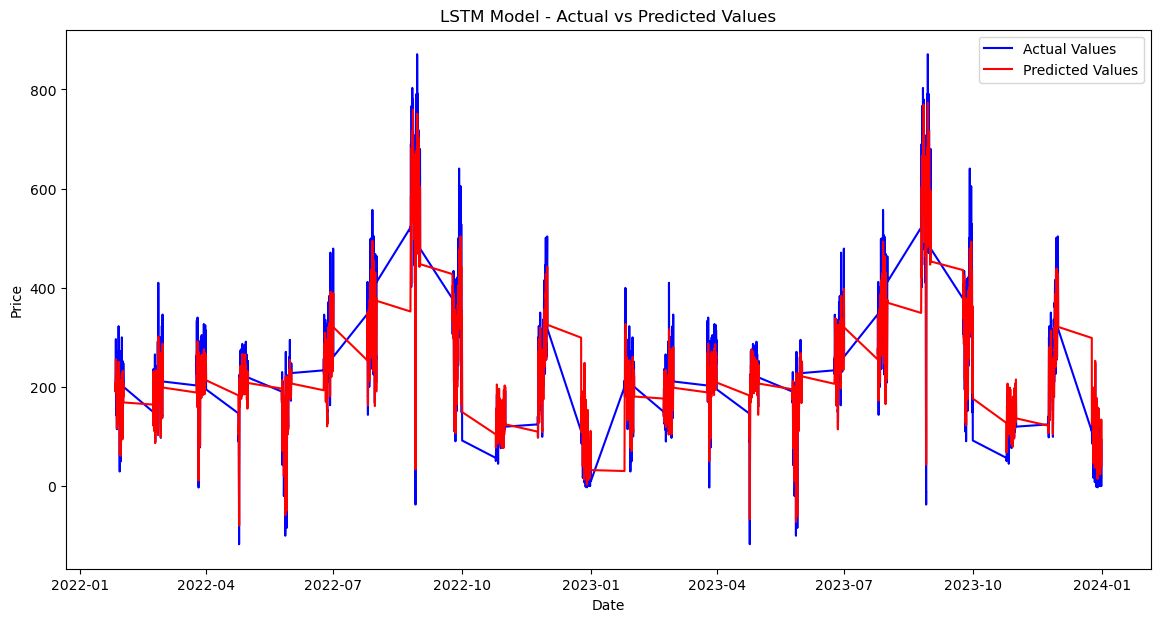

In [24]:
import matplotlib.pyplot as plt

# Make predictions on the test set
lstm_preds = lstm_model.predict(X_test)

# Invert scaling (if you scaled the data initially)
# In this case, we need to transform both predictions and true values back to original scale
lstm_preds_inverse = scaler.inverse_transform(
    np.concatenate((lstm_preds, X_test[:, -1, 1:]), axis=1))[:, 0]
y_test_inverse = scaler.inverse_transform(
    np.concatenate((y_test.reshape(-1, 1), X_test[:, -1, 1:]), axis=1))[:, 0]

# Create a time index for the test set based on the original data index
test_index = test_data.index[seq_length:]  # Adjust for sequence length

# Plot the predictions and actual values
plt.figure(figsize=(14, 7))
plt.plot(test_index, y_test_inverse, label="Actual Values", color="blue")
plt.plot(test_index, lstm_preds_inverse, label="Predicted Values", color="red")
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("LSTM Model - Actual vs Predicted Values")
plt.legend()
plt.show()

126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


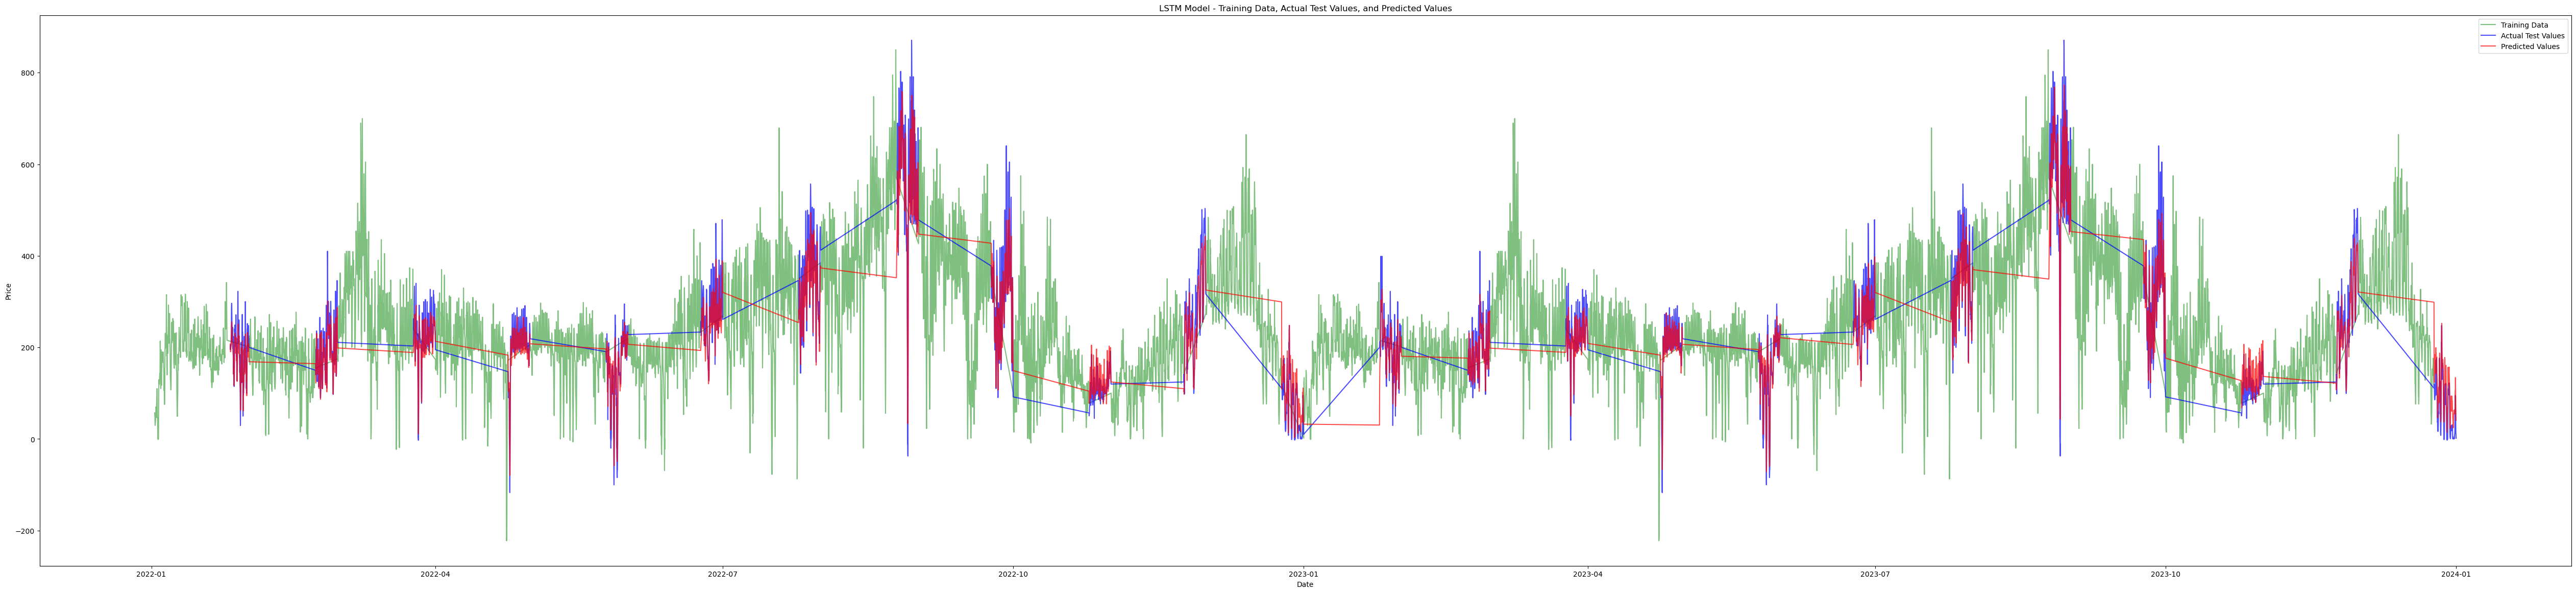

In [35]:
import matplotlib.pyplot as plt

# Make predictions on the test set
lstm_preds = lstm_model.predict(X_test)

# Invert scaling for both the predictions and true values if you scaled the data initially
# Concatenate with the other features to match the scaler's input shape
lstm_preds_inverse = scaler.inverse_transform(
    np.concatenate((lstm_preds, X_test[:, -1, 1:]), axis=1))[:, 0]
y_test_inverse = scaler.inverse_transform(
    np.concatenate((y_test.reshape(-1, 1), X_test[:, -1, 1:]), axis=1))[:, 0]

# Invert scaling for the training target values to plot the training data in its original scale
y_train_inverse = scaler.inverse_transform(
    np.concatenate((y_train.reshape(-1, 1), X_train[:, -1, 1:]), axis=1))[:, 0]

# Create a time index for the test set and training set
train_index = train_data.index[seq_length:]  # Adjust for sequence length
test_index = test_data.index[seq_length:]  # Adjust for sequence length

# Plot the training data, actual values, and predicted values
plt.figure(figsize=(64, 14))

# Plot training data
plt.plot(train_index, y_train_inverse, label="Training Data", color="green", alpha=0.5)

# Plot actual test values
plt.plot(test_index, y_test_inverse, label="Actual Test Values", color="blue", alpha=0.7)

# Plot predicted values
plt.plot(test_index, lstm_preds_inverse, label="Predicted Values", color="red", alpha=0.7)

# Labels and title
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("LSTM Model - Training Data, Actual Test Values, and Predicted Values")
plt.legend()
plt.show()


In [26]:
res_p_t = y_test_inverse - lstm_preds_inverse 

In [27]:
res_p_t[0:5]

array([-2.26482919, -2.44297033, 10.97283906,  2.3089307 ,  4.15648511])

In [28]:
y_test_inverse[0:5]

array([205. , 195.3, 201.5, 196.1, 201.5])

In [29]:
lstm_preds_inverse[0:5]

array([207.26482919, 197.74297033, 190.52716094, 193.7910693 ,
       197.34351489])

In [30]:
res_p_t.mean()

7.492117230054203

In [31]:
y_test[0:5]

array([0.39086852, 0.38199678, 0.38766737, 0.38272847, 0.38766737])

In [32]:
# Make predictions and calculate sMAPE
# lstm_preds = lstm_model.predict(X_test)
lstm_smape = smape(y_test_inverse, lstm_preds_inverse)
print(f"LSTM sMAPE: {lstm_smape:.2f}")

LSTM sMAPE: 19.62


In [80]:
lstm_smape = smape(y_test_inverse, lstm_preds_inverse)
print(f"LSTM sMAPE: {lstm_smape:.2f}")

LSTM sMAPE: 19.58


In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Calculate MAE
mae = mean_absolute_error(y_test_inverse, lstm_preds_inverse)
print(f"Mean Absolute Error (MAE): {mae:.2f}")

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_inverse, lstm_preds_inverse))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Mean Absolute Error (MAE): 30.10
Root Mean Squared Error (RMSE): 41.37


### im_2

In [42]:
import pandas as pd
import holidays

# # Load your dataset
# data = pd.read_csv('your_data.csv', parse_dates=['date'], index_col='date')

# Copy the original data for adding new features
data_im_hol = data_im.copy()

# Initialize the Netherlands holidays for 2022 and 2023
nl_holidays = holidays.Netherlands(years=[2022, 2023])

# Add a holiday flag to the dataset
data_im_hol['HolidayFlag'] = data_im_hol.index.to_series().apply(lambda x: 1 if x in nl_holidays else 0)

# Display the first few rows to verify
print(data_im_hol[['HolidayFlag']].head())

                     HolidayFlag
Date                            
2022-01-01 01:00:00            1
2022-01-01 02:00:00            1
2022-01-01 03:00:00            1
2022-01-01 04:00:00            1
2022-01-01 05:00:00            1


In [43]:
data_im_hol['WeekendFlag'] = data_im_hol.index.to_series().apply(lambda x: 1 if x.weekday() >= 5 else 0)

In [44]:
data_im_hol.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17520 entries, 2022-01-01 01:00:00 to 2024-01-01 00:00:00
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          17520 non-null  float64
 1   wind_offshore  17520 non-null  int64  
 2   wind_onshore   17520 non-null  int64  
 3   solar          17520 non-null  int64  
 4   total_load     17520 non-null  int64  
 5   DayOfWeek      17520 non-null  int32  
 6   WeekOfYear     17520 non-null  UInt32 
 7   Day            17520 non-null  int32  
 8   Month          17520 non-null  int32  
 9   Year           17520 non-null  int32  
 10  PeriodOfDay    17520 non-null  int32  
 11  HolidayFlag    17520 non-null  int64  
 12  WeekendFlag    17520 non-null  int64  
dtypes: UInt32(1), float64(1), int32(5), int64(6)
memory usage: 2.0 MB


In [45]:
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data_im_hol), columns=data_im_hol.columns, index=data_im_hol.index)

In [48]:
train_data, test_data = train_test_split(data_scaled)
seq_length = 24
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

In [49]:
# 3. Define and Train the LSTM Model
def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, activation='relu', input_shape=input_shape),
        Dropout(0.2),  # Regularization to prevent overfitting
        Dense(1)  # Output layer for regression
    ])
    model.compile(optimizer='adam', loss='mae')
    return model

# Set input shape for the LSTM
input_shape = (X_train.shape[1], X_train.shape[2])


In [50]:
# Initialize and train the model
lstm_model = create_lstm_model(input_shape)
lstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)


Epoch 1/10


/Users/libin/anaconda3/envs/th/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


379/379 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.1019 - val_loss: 0.0481
Epoch 2/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0564 - val_loss: 0.0606
Epoch 3/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0479 - val_loss: 0.0296
Epoch 4/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0406 - val_loss: 0.0294
Epoch 5/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0370 - val_loss: 0.0269
Epoch 6/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0348 - val_loss: 0.0245
Epoch 7/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0319 - val_loss: 0.0258
Epoch 8/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0301 - val_loss: 0.0199
Epoch 9/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0293 - val_loss: 0.0204
Epoch 10/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0276 - val_loss: 0.0216


In [51]:
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Invert scaling for predictions and true values if scaling was applied
lstm_preds = lstm_model.predict(X_test)
lstm_preds_inverse = scaler.inverse_transform(
    np.concatenate((lstm_preds, X_test[:, -1, 1:]), axis=1))[:, 0]
y_test_inverse = scaler.inverse_transform(
    np.concatenate((y_test.reshape(-1, 1), X_test[:, -1, 1:]), axis=1))[:, 0]

# Calculate MAE and RMSE
mae = mean_absolute_error(y_test_inverse, lstm_preds_inverse)
rmse = np.sqrt(mean_squared_error(y_test_inverse, lstm_preds_inverse))
smape_value = smape(y_test_inverse, lstm_preds_inverse)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Symmetric Mean Absolute Percentage Error (sMAPE): {smape_value:.2f}")

126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Mean Absolute Error (MAE): 28.06
Root Mean Squared Error (RMSE): 38.07
Symmetric Mean Absolute Percentage Error (sMAPE): 19.58


In [65]:
from kerastuner import HyperModel
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam

class LSTMHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32), 
                       activation='relu', 
                       input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dropout(rate=hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
        model.add(Dense(1))
        
        # Set learning rate in the optimizer
        optimizer = Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4]))
        model.compile(optimizer=optimizer, loss='mae')
        
        return model

In [66]:
from kerastuner import RandomSearch

# Initialize the tuner
tuner = RandomSearch(
    LSTMHyperModel(),
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='lstm_tuning',
    project_name='lstm_hyperparameter_tuning'
)

### Energy generation Feature

In [89]:
data.corr()['price']

price            1.000000
wind_offshore   -0.448885
wind_onshore    -0.322229
solar           -0.099700
total_load       0.212870
Name: price, dtype: float64

In [92]:
data_im_hol.corr()['price']

price            1.000000
wind_offshore   -0.448885
wind_onshore    -0.322229
solar           -0.099700
total_load       0.212870
DayOfWeek       -0.072007
WeekOfYear       0.142568
Day              0.022376
Month            0.157936
Year            -0.000417
PeriodOfDay      0.147344
HolidayFlag     -0.131571
WeekendFlag     -0.126661
Name: price, dtype: float64

In [185]:
import pandas as pd

# Load your dataset (assuming it's already indexed by date)
# data = pd.read_csv('your_data.csv', parse_dates=['date'], index_col='date')
data_lag = data_im_hol.copy()
# # Define the features for which you want to create lagged versions
# features_to_lag = ['price', 'wind_offshore', 'wind_onshore', 'solar', 'total_load']

# # Define the lag intervals (e.g., previous 1 hour, 24 hours, and 168 hours for daily and weekly patterns)
# lag_intervals = [1, 24, 168]  # 1 hour, 1 day (24 hours), and 1 week (168 hours)

# # Create lagged features
# for feature in features_to_lag:
#     for lag in lag_intervals:
#         data_lag[f'{feature}_lag_{lag}'] = data_lag[feature].shift(lag)

# Drop rows with NaN values that result from the lagging
data_with_lags = data_lag.dropna()

# Display the first few rows to verify
print(data_with_lags.head())


                      price  wind_offshore  wind_onshore  solar  total_load  \
Date                                                                          
2022-01-01 01:00:00  124.70           5411         10585      0       46129   
2022-01-01 02:00:00  124.70           5230          9679      0       44340   
2022-01-01 03:00:00  134.00           4939          8647      0       43222   
2022-01-01 04:00:00   58.80           4517          7819      0       42705   
2022-01-01 05:00:00   37.67           4176          6827      0       42576   

                     DayOfWeek  WeekOfYear  Day  Month  Year  PeriodOfDay  \
Date                                                                        
2022-01-01 01:00:00          5          52    1      1  2022            1   
2022-01-01 02:00:00          5          52    1      1  2022            2   
2022-01-01 03:00:00          5          52    1      1  2022            3   
2022-01-01 04:00:00          5          52    1      1  2022 

In [186]:
data_with_lags.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17520 entries, 2022-01-01 01:00:00 to 2024-01-01 00:00:00
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          17520 non-null  float64
 1   wind_offshore  17520 non-null  int64  
 2   wind_onshore   17520 non-null  int64  
 3   solar          17520 non-null  int64  
 4   total_load     17520 non-null  int64  
 5   DayOfWeek      17520 non-null  int32  
 6   WeekOfYear     17520 non-null  UInt32 
 7   Day            17520 non-null  int32  
 8   Month          17520 non-null  int32  
 9   Year           17520 non-null  int32  
 10  PeriodOfDay    17520 non-null  int32  
 11  HolidayFlag    17520 non-null  int64  
 12  WeekendFlag    17520 non-null  int64  
dtypes: UInt32(1), float64(1), int32(5), int64(6)
memory usage: 2.0 MB


In [187]:
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data_with_lags), columns=data_with_lags.columns, index=data_with_lags.index)

In [188]:
train_data, test_data = train_test_split(data_scaled)
seq_length = 24
X_train_g, y_train_g = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

In [190]:

def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, activation='relu', input_shape=input_shape),
        Dropout(0.2),  # Regularization to prevent overfitting
        Dense(1)  # Output layer for regression
    ])
    model.compile(optimizer='adam', loss='mae')
    return model

# model = Sequential()
# model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
# model.add(LSTM(64, return_sequences=False))
# model.add(Dense(25))
# model.add(Dense(1))


def create_lstm_model_2(input_shape):
    model = Sequential([
        LSTM(128, return_sequences=True, activation='relu', input_shape=input_shape),
        LSTM(64, activation='relu', return_sequences=False),
        Dense(25),
        # Dropout(0.2),  # Regularization to prevent overfitting
        Dense(1)  # Output layer for regression
    ])
    model.compile(optimizer='adam', loss='mae')
    return model

# Set input shape for the LSTM
input_shape = (X_train_g.shape[1], X_train_g.shape[2])

In [191]:
X_train_g.shape

(13463, 24, 13)

In [192]:
# Initialize and train the model
lstm_model_g = create_lstm_model_2(input_shape)
lstm_model_g.fit(X_train_g, y_train, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10


/Users/libin/anaconda3/envs/th/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


379/379 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.0759 - val_loss: 0.0368
Epoch 2/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0371 - val_loss: 0.0273
Epoch 3/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0293 - val_loss: 0.0253
Epoch 4/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0248 - val_loss: 0.0190
Epoch 5/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0221 - val_loss: 0.0196
Epoch 6/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0207 - val_loss: 0.0183
Epoch 7/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0200 - val_loss: 0.0219
Epoch 8/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0201 - val_loss: 0.0164
Epoch 9/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0192 - val_loss: 0.0171
Epoch 10/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0199 - val_loss: 0.0163


In [193]:
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Invert scaling for predictions and true values if scaling was applied
lstm_preds_g = lstm_model_g.predict(X_test)
lstm_preds_g_inverse = scaler.inverse_transform(
    np.concatenate((lstm_preds_g, X_test[:, -1, 1:]), axis=1))[:, 0]
y_test_inverse = scaler.inverse_transform(
    np.concatenate((y_test.reshape(-1, 1), X_test[:, -1, 1:]), axis=1))[:, 0]

# Calculate MAE and RMSE
mae = mean_absolute_error(y_test_inverse, lstm_preds_g_inverse)
rmse = np.sqrt(mean_squared_error(y_test_inverse, lstm_preds_g_inverse))
smape_value = smape(y_test_inverse, lstm_preds_g_inverse)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Symmetric Mean Absolute Percentage Error (sMAPE): {smape_value:.2f}")

126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Mean Absolute Error (MAE): 26.18
Root Mean Squared Error (RMSE): 36.68
Symmetric Mean Absolute Percentage Error (sMAPE): 17.88


In [ ]:
# Mean Absolute Error (MAE): 32.55
# Root Mean Squared Error (RMSE): 43.41
# Symmetric Mean Absolute Percentage Error (sMAPE): 20.86

In [113]:
data_with_lags.corr()['price']

price                    1.000000
wind_offshore           -0.445220
wind_onshore            -0.319112
solar                   -0.104201
total_load               0.219675
DayOfWeek               -0.071564
WeekOfYear               0.144683
Day                      0.012327
Month                    0.149140
Year                    -0.007513
PeriodOfDay              0.146720
HolidayFlag             -0.126964
WeekendFlag             -0.124777
price_lag_1              0.957893
price_lag_24             0.834086
price_lag_168            0.688325
wind_offshore_lag_1     -0.444944
wind_offshore_lag_24    -0.353679
wind_offshore_lag_168   -0.208631
wind_onshore_lag_1      -0.316654
wind_onshore_lag_24     -0.270371
wind_onshore_lag_168    -0.196174
solar_lag_1             -0.064977
solar_lag_24            -0.090631
solar_lag_168           -0.074024
total_load_lag_1         0.186592
total_load_lag_24        0.204332
total_load_lag_168       0.179481
Name: price, dtype: float64

### Benchmark

In [176]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17520 entries, 2022-01-01 01:00:00 to 2024-01-01 00:00:00
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          17520 non-null  float64
 1   wind_offshore  17520 non-null  int64  
 2   wind_onshore   17520 non-null  int64  
 3   solar          17520 non-null  int64  
 4   total_load     17520 non-null  int64  
dtypes: float64(1), int64(4)
memory usage: 1.3 MB


In [195]:
import pandas as pd

# Load your dataset (assuming it's already indexed by date)
# data = pd.read_csv('your_data.csv', parse_dates=['date'], index_col='date')
data_b = data_im.copy()
# Define the features for which you want to create lagged versions
# features_to_lag = ['price']

# # Define the lag intervals (e.g., previous 1 hour, 24 hours, and 168 hours for daily and weekly patterns)
# lag_intervals = [1, 24, 168]  # 1 hour, 1 day (24 hours), and 1 week (168 hours)

# # Create lagged features
# for feature in features_to_lag:
#     for lag in lag_intervals:
#         data_b[f'{feature}_lag_{lag}'] = data_b[feature].shift(lag)

# Drop rows with NaN values that result from the lagging
data_b = data_b.dropna()

# Display the first few rows to verify
print(data_b.head())

                      price  DayOfWeek  WeekOfYear  Day  Month  Year  \
Date                                                                   
2022-01-01 01:00:00  124.70          5          52    1      1  2022   
2022-01-01 02:00:00  124.70          5          52    1      1  2022   
2022-01-01 03:00:00  134.00          5          52    1      1  2022   
2022-01-01 04:00:00   58.80          5          52    1      1  2022   
2022-01-01 05:00:00   37.67          5          52    1      1  2022   

                     PeriodOfDay  
Date                              
2022-01-01 01:00:00            1  
2022-01-01 02:00:00            2  
2022-01-01 03:00:00            3  
2022-01-01 04:00:00            4  
2022-01-01 05:00:00            5  


In [196]:
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data_b), columns=data_b.columns, index=data_b.index)
train_data, test_data = train_test_split(data_scaled)
seq_length = 24
X_train_b, y_train_b = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

In [197]:
X_train_b.shape

(13463, 24, 7)

In [198]:
def create_lstm_model_2(input_shape):
    model = Sequential([
        LSTM(128, return_sequences=True, activation='relu', input_shape=input_shape),
        LSTM(64, activation='relu', return_sequences=False),
        Dense(25),
        # Dropout(0.2),  # Regularization to prevent overfitting
        Dense(1)  # Output layer for regression
    ])
    model.compile(optimizer='adam', loss='mae')
    return model

# Set input shape for the LSTM
input_shape = (X_train_b.shape[1], X_train_b.shape[2])

In [199]:
# Initialize and train the model
lstm_model_b = create_lstm_model_2(input_shape)
lstm_model_b.fit(X_train_b, y_train_b, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10


/Users/libin/anaconda3/envs/th/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


379/379 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0796 - val_loss: 0.0468
Epoch 2/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0463 - val_loss: 0.0358
Epoch 3/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0321 - val_loss: 0.0262
Epoch 4/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0253 - val_loss: 0.0204
Epoch 5/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0231 - val_loss: 0.0191
Epoch 6/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0207 - val_loss: 0.0216
Epoch 7/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0209 - val_loss: 0.0234
Epoch 8/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0211 - val_loss: 0.0170
Epoch 9/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.0195 - val_loss: 0.0197
Epoch 10/10
379/379 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0195 - val_loss: 0.0187


In [200]:
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Invert scaling for predictions and true values if scaling was applied
lstm_preds_b = lstm_model_b.predict(X_test)
lstm_preds_b_inverse = scaler.inverse_transform(
    np.concatenate((lstm_preds_b, X_test[:, -1, 1:]), axis=1))[:, 0]
y_test_inverse = scaler.inverse_transform(
    np.concatenate((y_test.reshape(-1, 1), X_test[:, -1, 1:]), axis=1))[:, 0]

# Calculate MAE and RMSE
mae = mean_absolute_error(y_test_inverse, lstm_preds_b_inverse)
rmse = np.sqrt(mean_squared_error(y_test_inverse, lstm_preds_b_inverse))
smape_value = smape(y_test_inverse, lstm_preds_b_inverse)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Symmetric Mean Absolute Percentage Error (sMAPE): {smape_value:.2f}")

126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Mean Absolute Error (MAE): 23.32
Root Mean Squared Error (RMSE): 33.60
Symmetric Mean Absolute Percentage Error (sMAPE): 16.21


In [202]:
from dieboldmariano import dm_test

T = y_test_inverse
F = lstm_preds_inverse
G = lstm_preds_g_inverse

dm_test(T, F, G, one_sided=True)

(2.056933684493621, 0.9801214091105025)

In [156]:
x = lstm_preds_inverse - lstm_preds_g_inverse